In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


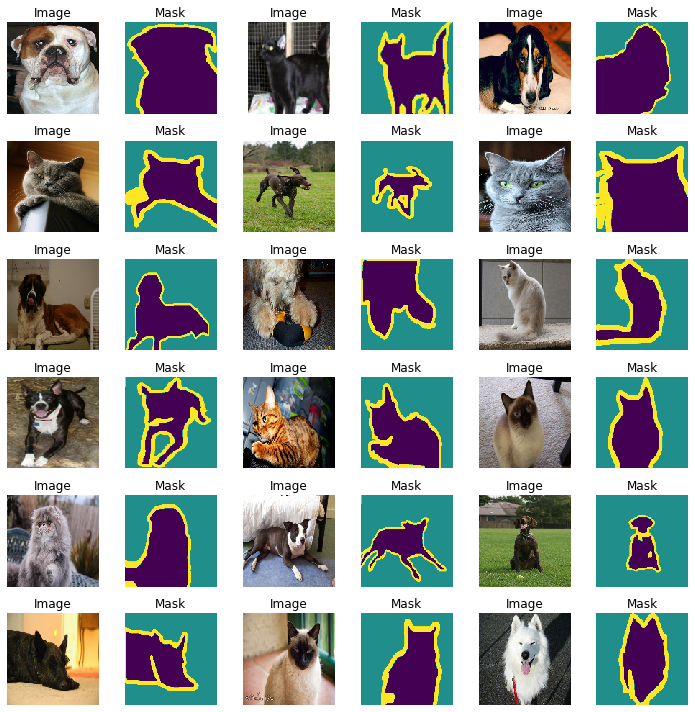

In [4]:
# 1) TFDS label to split dataset

dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

raw_train = dataset['train']
raw_test = dataset['test']

############################################################

# 2) Datasets to (image, label) datasets

IMG_SIZE = (128, 128)

def format_data(datapoint):
    image = datapoint['image']
    mask = datapoint['segmentation_mask']
    
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    image = tf.image.resize(image, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE)
    
    #Originally included randomly flipping training data left and right, not sure why though
    
    return image, mask

train = raw_train.map(format_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = raw_test.map(format_data)

############################################################

# 3) Datasets to batched dataset

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_batches = (train
                 .cache()
                 .shuffle(SHUFFLE_BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .repeat()
                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
test_batches = test.batch(BATCH_SIZE)

############################################################

# 4) Datasets to image display

def plotImages(batch):
    img, mask = batch
    
    plt.figure(figsize=(10,10))
    
    for n in range(18):
        
        plt.subplot(6,6,2*n+1)
        plt.imshow(img[n])
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(6,6,2*n+2)
        mask_image = tf.keras.preprocessing.image.array_to_img(mask[n])
        plt.imshow(mask_image)
        plt.title('Mask')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

sample_train_batch = next(iter(train_batches))
plotImages(sample_train_batch) 


In [5]:
OUTPUT_CHANNELS = 3
IMG_SHAPE = (*IMG_SIZE, OUTPUT_CHANNELS)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)

model.summary()

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

class DisplayCallback(tf.keras.callbacks.Callback):
    
    def create_mask(pred_mask):
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        return pred_mask[0]

    def show_predictions(dataset=None, num=1):
        if dataset:
            for image, mask in dataset.take(num):
                pred_mask = model.predict(image)
                display([image[0], mask[0], create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
            
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 64, 64, 96), 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8, 8, 1088)   0           sequential_4[0][0]               
                                                                 model_2[1][3]              